In [93]:
import os
import gc
import sys
sys.path.append("../..")
import time

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn import preprocessing
import xgboost as xgb

from Other.utils.ReduceMem import read_and_reduce, merge_and_reduce

In [22]:
def check_and_drop_column(df, column):
    if column in df.columns:
        df.drop(columns=[column], axis=1, inplace=True)

In [42]:
def print_columns(df):
    s = ''
    for col in df.columns:
        s += '"%s", ' % col
    print(s[:-2])

# Preprocessing

In [49]:
V_cols_train = read_and_reduce('../data/V_cols_train.csv')
V_cols_test = read_and_reduce('../data/V_cols_test.csv')

Mem. usage decreased to 342.98 Mb (70.8% reduction)
Mem. usage decreased to 301.53 Mb (70.0% reduction)


In [3]:
print(V_cols_train.shape)
print(V_cols_test.shape)

(590540, 261)
(506691, 260)


In [4]:
trans_train = read_and_reduce('../data/jinoo_train.csv')
trans_test = read_and_reduce('../data/jinoo_test.csv')

Mem. usage decreased to 33.79 Mb (53.1% reduction)
Mem. usage decreased to 28.99 Mb (53.1% reduction)


In [5]:
print(trans_train.shape)
print(trans_test.shape)

(590540, 16)
(506691, 16)


In [6]:
trans_train.columns

Index(['TransactionID', 'card1_count_full', 'card2_count_full',
       'card3_count_full', 'card4_count_full', 'card5_count_full',
       'card6_count_full', 'addr1_count_full', 'addr2_count_full',
       'Transaction_day_of_week', 'Transaction_hour_of_day',
       'TransactionAmt_to_mean_card1', 'TransactionAmt_to_mean_card4',
       'TransactionAmt_to_std_card1', 'TransactionAmt_to_std_card4',
       'emaildomain'],
      dtype='object')

In [19]:
pwd

'/home/jinoo/ybigta/ybigta_first_proj/Models/2_combined_model_2'

In [20]:
# Original data
orig_trans_train = read_and_reduce('../../../Data/train_transaction.csv')
orig_id_train = read_and_reduce('../../../Data/train_identity.csv')
orig_trans_test = read_and_reduce('../../../Data/test_transaction.csv')
orig_id_test = read_and_reduce('../../../Data/test_identity.csv')

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [40]:
# 원본 데이터 merge
orig_train = orig_trans_train.merge(orig_id_train, how='left', on='TransactionID')
orig_test = orig_trans_test.merge(orig_id_test, how='left', on='TransactionID')

In [58]:
# 민태꺼 V 빼기
for col in orig_train.columns:
    if str(col)[0] == 'V':
        check_and_drop_column(orig_train, col)
        
for col in orig_test.columns:
    if str(col)[0] == 'V':
        check_and_drop_column(orig_test, col)

In [59]:
# 준형이형꺼 처리
#id_30

def os(df):
    if df == "-999":
        df = -999
    elif "Windows" in df:
        df = "Windows"
    elif "Mac" in df:
        df = "Mac"
    elif "iOS" in df:
        df = "ios"
    elif "Android" in df:
        df = "Android"
    else:
        df = "other"
        
    return df

orig_train["id_30"].fillna("-999", inplace=True)
orig_train["OS"] = orig_train["id_30"].apply(os)

orig_test["id_30"].fillna("-999", inplace=True)
orig_test["OS"] = orig_test["id_30"].apply(os)

#id_31 
# latest 여부 / 브라우저 col 생성
latest_browser_list = ["samsung browser 7.0",
                  "opera 53.0",
                  "mobile safari 10.0",
                  "google search application 49.0",
                  "firefox 60.0",
                  "edge 17.0",
                  "chrome 69.0", 
                  "chrome 67.0 for android",
                  "chrome 63.0 for android",
                  "chrome 63.0 for ios",
                  "chrome 64.0",
                  "chrome 64.0 for android",
                  "chrome 64.0 for ios",
                  "chrome 65.0",
                  "chrome 65.0 for android",
                  "chrome 65.0 for ios",
                  "chrome 66.0",
                  "chrome 66.0 for android",
                  "chrome 66.0 for ios"
                 ]

def latest_browser(df):
    if df == "-999":
        df = -999
    elif df in latest_browser_list:
        df = 1
    else:
        df = 0
    return df

def browser(df):
    if df == "-999":
        df = -999
    elif "chrome" in df:
        df = "chrome"
    elif "safari" in df:
        df = "safari"
    elif "firefox" in df:
        df = "firefox"
    elif "ie" in df:
        df = "ie"
    elif "samsung" in df:
        df = "samsumg"
    elif "Samsung" in df:
        df = "samsumg"
    return df 
    

orig_train["id_31"].fillna("-999", inplace=True)
orig_train["Latest_browser"] = orig_train["id_31"].apply(latest_browser)
orig_train["Browser"] = orig_train["id_31"].apply(browser)

orig_test["id_31"].fillna("-999", inplace=True)
orig_test["Latest_browser"] = orig_test["id_31"].apply(latest_browser)
orig_test["Browser"] = orig_test["id_31"].apply(browser)

In [ ]:
# 민태꺼 'isFraud' drop
V_cols_train = V_cols_train.drop('isFraud', axis=1)
V_cols_test = V_cols_test.drop('isFraud', axis=1)

In [60]:
# 민태꺼 V merge
train_V = orig_train.merge(V_cols_train, how='left', on='TransactionID')
test_V = orig_test.merge(V_cols_test, how='left', on='TransactionID')

In [61]:
# 내꺼까지 merge
train = train_V.merge(trans_train, how='left', on='TransactionID')
test = test_V.merge(trans_test, how='left', on='TransactionID')

Text(0.5, 1.0, 'TransactionAmt Distribution')

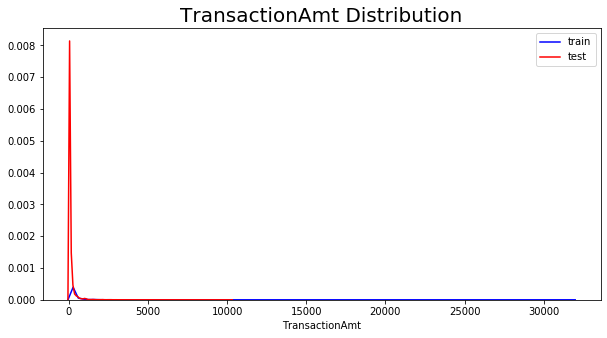

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# 민태 TransactionAmt log regularization 그래프
f, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.distplot(train['TransactionAmt'], bins=3, hist=False, ax=ax1,label='train',color='b')
ax = sns.distplot(test['TransactionAmt'], bins=3, hist=False, ax=ax1, label='test',color='r')
ax1.set_title('TransactionAmt Distribution', fontsize=20)

In [66]:
train['TransactionAmt'] = np.log(train['TransactionAmt']+1)
test['TransactionAmt'] = np.log(test['TransactionAmt']+1)

Text(0.5, 1.0, 'TransactionAmt Distribution')

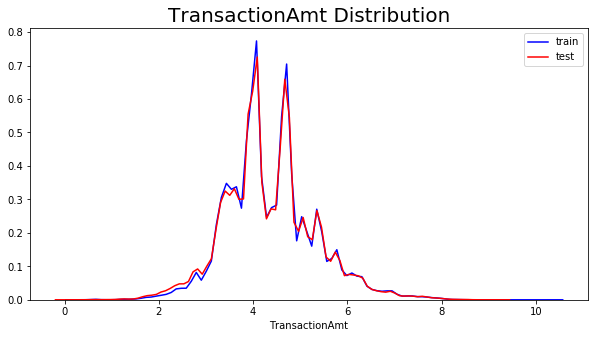

In [67]:
f, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.distplot(train['TransactionAmt'], bins=3, hist=False, ax=ax1,label='train',color='b')
ax = sns.distplot(test['TransactionAmt'], bins=3, hist=False, ax=ax1, label='test',color='r')
ax1.set_title('TransactionAmt Distribution', fontsize=20)

In [68]:
print(train.shape)
print(test.shape)

(590540, 372)
(506691, 371)


In [70]:
dir_name = 'merged_data'
train.to_csv('./{directory}/train.csv'.format(directory=dir_name), index=False)
test.to_csv('./{directory}/test.csv'.format(directory=dir_name), index=False)

###  원본  데이터 merge -> 민태꺼 V 있는거 빼기 -> 민태꺼 추가 -> 내꺼 추가 -> 준형이형꺼 추가

# XGBoost

In [71]:
y_train = train['isFraud'].copy()

In [72]:
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

In [73]:
# Fill numeric columns' NaN values with mean
for c in X_train.columns:
    if X_train[c].dtype=='float16' or  X_train[c].dtype=='float32' or  X_train[c].dtype=='float64':
        X_train[c].fillna(X_train[c].mean())
        X_test[c].fillna(X_train[c].mean())

In [74]:
# Fill categorical columns' NaN values with placeholder (-999)
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

In [75]:
# Label-Encode categorical columns
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

In [90]:
# Set up K-Fold
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True)

print(folds)

KFold(n_splits=5, random_state=None, shuffle=True)


In [91]:
# Initialize submission DataFrame
sample_submission = pd.read_csv('../../../Data/sample_submission.csv')
xgb_submission = sample_submission.copy()
xgb_submission['isFraud'] = 0

XGBoost --> Tree method: gpu_hist, Fold_N: 5
-------------------------------------------------------
Fold 0 started..., Time: 2019-8-17 16:3:12


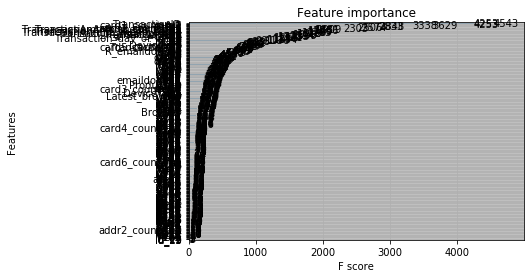

Feature importances: 
 [0.00159179 0.00180496 0.00219636 0.0036959  0.00163284 0.00187358
 0.00356749 0.00119898 0.00169182 0.0047018  0.0016901  0.00559079
 0.00169316 0.00108677 0.00173723 0.00327112 0.00607419 0.00214763
 0.00231509 0.00359959 0.00187699 0.00225751 0.00729273 0.00526192
 0.00223609 0.00276801 0.003769   0.00514165 0.00355153 0.00840261
 0.00192137 0.00300577 0.00171338 0.00170902 0.00108578 0.00168279
 0.00104959 0.00142528 0.000855   0.00172038 0.00146931 0.00143633
 0.00176658 0.00116533 0.00194123 0.00052989 0.00131817 0.00197109
 0.00272403 0.00251085 0.00209759 0.00118492 0.00119083 0.00124452
 0.00197104 0.00125236 0.00258282 0.00196022 0.00111932 0.00117518
 0.00135687 0.00149295 0.0025793  0.00061843 0.00099109 0.00041809
 0.00120694 0.00145505 0.00114967 0.00105289 0.00614688 0.00114474
 0.00100747 0.00138298 0.00182463 0.00520781 0.00176791 0.00084429
 0.00125166 0.00118743 0.00036618 0.00055315 0.00032055 0.00161489
 0.00132261 0.00603209 0.00159242 0.001

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [94]:
# auto, exact, approx, hist, gpu_hist (https://xgboost.readthedocs.io/en/latest/parameter.html)
tree_method = 'gpu_hist'
print('XGBoost --> Tree method: {}, Fold_N: {}'.format(tree_method, n_fold))
print('-------------------------------------------------------')

# Set timezone
os.environ['TZ'] = 'Asia/Seoul'
time.tzset()

# Execute K-Fold XGBoost
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train)):
    xgbclf = xgb.XGBClassifier(
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.048,
        subsample=0.85,
        colsample_bytree=0.85,
        missing=-999,
        tree_method=tree_method,
        reg_alpha=0.15,
        reg_lamdba=0.85
    )

    # Print current iteration information
    start = time.time()
    now = time.localtime(start)
    print('Fold {} started..., Time: {yy}-{mm}-{dd} {hh}:{MM}:{ss}'.format(fold_n, yy=now.tm_year, mm=now.tm_mon, dd=now.tm_mday, hh=now.tm_hour, MM=now.tm_min, ss=now.tm_sec))
    
    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    xgbclf.fit(X_train_,y_train_)
    del X_train_,y_train_
    pred=xgbclf.predict_proba(X_test)[:,1]
    val=xgbclf.predict_proba(X_valid)[:,1]
    
    # Feature importances
    xgb.plot_importance(xgbclf)
    plt.show()
    print('Feature importances: \n', xgbclf.feature_importances_)
    
    del xgbclf, X_valid
    
    # Measure time elapsed
    now = time.time()
    time_elapsed = now - start
    print('Completed, Time elapsed: {} seconds'.format(time_elapsed))
    
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    print('F1 Score: {}'.format(f1_score(y_valid, val)))
    del val,y_valid
    xgb_submission['isFraud'] = xgb_submission['isFraud']+pred/n_fold
    del pred
    gc.collect()
    
    print('-------------------------------------------------------')
    
print('Done.')

In [82]:
dir_name = 'submission'
xgb_submission.to_csv('./{directory}/sub_xgboost.csv'.format(directory=dir_name), index=False)
xgb_submission.head()

,TransactionID,isFraud
0,3663549,0.000668
1,3663550,0.000819
2,3663551,0.000199
3,3663552,0.001080
4,3663553,0.000416
